In [1]:
# Fundamental
import sys, re, random, operator, time
import datetime, json, pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#ML
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Query
import urllib3 as url
import xml.etree.ElementTree as ET

# Visualize
import seaborn as sns

### Parameters + Instancing

In [2]:
http = url.PoolManager()
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.max_seq_items = 100
%matplotlib inline

In [24]:
# Propublica paths
ppdelay = .25 # API delay
pplimit = 74 # Pause Requests
pppath = "https://projects.propublica.org/nonprofits/api/v2"
ppsearch = lambda x: "/search.json?q="+x
pporg = lambda x: "/organizations/"+str(x)+".json"
ppsearch = lambda x: "/search.json?q="+str(x).replace(" ", "%20")

# S3 Paths
s3path = "https://s3.amazonaws.com/irs-form-990"
s3index = lambda x: "/index_"+str(x)+".csv"
s3xml = lambda x:"/"+str(x)+"_public.xml"

### Core Functions
##### Methods for handling Propublica API

In [4]:
def get_eins_by_search(q,state=None,ntee=None,ccode=None):
    # q is string query
    # State string ed, eg NY
    # ntee is National Taxonomy of Exempt Entities (NTEE) Major Group, by Integer
    # ccode is organization category code by Integer, eg. 3 is 501(c)3
    # https://projects.propublica.org/nonprofits/api#methods
    query = ""
    query+="&state%5Bid%5D="+str(state) if state!=None else ""
    query+="ntee%5Bid%5D="+str(ntee) if ntee!=None else ""
    query+="c_code%5Bid%5D="+str(ccode) if ccode!=None else ""
    print(pppath+ppsearch(q)+query)
    response = http.request('GET',pppath+ppsearch(q)+query)
    parsed = json.loads(response.data.decode('utf-8'))
    r = json.dumps(parsed["organizations"], indent=4, sort_keys=True)
#     print(r)
    return pd.read_json(r,orient="index").T

In [48]:
def get_by_ein(ein,year=None):
    # Returns dataframe of FILING OBJECTS for that Organziation
    # https://projects.propublica.org/nonprofits/api#filing-object
    response = http.request('GET',pppath+pporg(ein))
    parsed = json.loads(response.data.decode('utf-8'))
    r = json.dumps(parsed["filings_with_data"], indent=4, sort_keys=True)
    # If there is nothing in the response
    if(len(r)<=2): 
        return pd.DataFrame([{"ein":ein,"tax_prd_yr":year}])
    else:
        df =  pd.read_json(r,orient="index").T.set_index('tax_prd_yr')
        if year != None: # If a year is specified
            if (int(year) in df.index) == False: # Make sure that year is there, if not return empty row
                return pd.DataFrame([{"ein":ein,"tax_prd_yr":year}])
            else: # otherwise return year as series
                return df.loc[year] # Return year
        else: # Otherwise return all years available
            return df
#     df.loc[year] if year!=None else df
#     return df.loc[year] if year!=None else df

In [45]:
def get_by_eins_and_year(einlist,year):
    # Accepts list of EINs
    # Populates filing objects per row
    df = pd.DataFrame()
    count = 0
    for ein in einlist:
        print(count, ein,year)
        count+=1
        try:
            row = get_by_ein(ein,year)
            df = df.append(row)
        except:
            print("Rate limit at " + str(count) + " with " + str(ppdelay) + " seconds")
        if count%pplimit != 0: time.sleep(ppdelay)
        else: time.sleep(10) # Cooldown
    return df

In [7]:
def search_by_name(name, zipcode, returnlist=False):
    # Retrieve EIN results by name
    # If returnlist==True, Return full list or rtruncated list
    # If returnlist==False, return most likely
    return ein

##### Methods for handling AWS hosted IRS xml

In [8]:
def get_unique_from_ein(year,ein):
    df = pd.read_csv(s3path+s3index(str(year)))
    objid = df[df["EIN"]==ein].OBJECT_ID
    return objid.values[0]

In [9]:
def get_990_to_df(objid):
    response = http.request('GET',s3path+s3xml(objid))
    root = ET.fromstring(response.data.decode('utf-8')) # element tree
    print(root)
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
            all_records.append(record)
    return pd.DataFrame(all_records)

In [10]:
def get_990_to_xml(objid):
    response = http.request('GET',s3path+s3xml(objid))
    root = ET.fromstring(response.data.decode('utf-8')) # element tree
    return root

### Explore
[Dictionary](https://github.com/CharityNavigator/irs990/blob/master/docs/explore-database.md)

In [ ]:
r = get_unique_from_ein(2015,382912028)
df=get_990_to_df(r)
df

In [ ]:
t=get_by_ein(382912028)


In [ ]:
get_by_ein(530196583,2015)

In [ ]:
# Example of Searching and then plotting
t = get_by_ein(get_eins_by_search("New America",state="DC")['ein'][0])

In [ ]:
sns.stripplot(x="tax_prd_yr",y="totfuncexpns", data=t.reset_index());

In [51]:
newdf = get_by_eins_and_year(get_eins_by_search("software",state="DC")["ein"], 2015)

https://projects.propublica.org/nonprofits/api/v2/search.json?q=software&state%5Bid%5D=DC
0 133768378 2015


/home/ubuntu/anaconda3/lib/python3.5/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


1 521329859 2015


/home/ubuntu/anaconda3/lib/python3.5/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2 61242574 2015


/home/ubuntu/anaconda3/lib/python3.5/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [52]:
newdf

,compnsatncurrofcr,cstbasisecur,cstbasisothr,ein,formtype,gftgrntsrcvd170,gnlsecur,gnlsothr,grsalesecur,grsalesinvent,...,totprgmrevnue,totrevenue,totsupp509,txexmptbndsend,txexmptbndsproceeds,txrevnuelevied170,txrevnuelevied509,unrelbusinccd,unsecurednotesend,updated
2015,3066008.0,1929368.0,31038.0,133768378.0,0.0,0.0,460978.0,-31038.0,2390346.0,0.0,...,31106393.0,32370376.0,0.0,0.0,0.0,0.0,0.0,N,0.0,2017-06-30T00:37:49.920Z
2015,675856.0,3118735.0,0.0,521329859.0,0.0,0.0,633629.0,0.0,3752364.0,0.0,...,11831698.0,12360513.0,0.0,0.0,0.0,0.0,0.0,N,0.0,2017-06-30T00:36:49.104Z
2015,2484304.0,0.0,0.0,61242574.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58843547.0,59649423.0,0.0,0.0,0.0,0.0,0.0,N,0.0,2017-06-30T00:38:18.366Z


In [31]:
sns.kdeplot(["totfuncexpns"], data=newdf);

TypeError: kdeplot() got multiple values for argument 'data'

/home/ubuntu/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


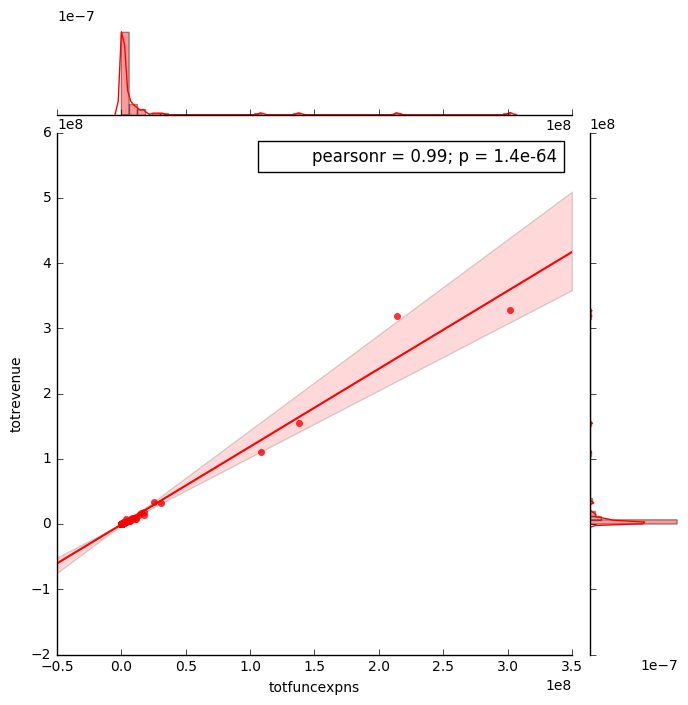

In [33]:
sns.jointplot("totfuncexpns", "totrevenue", data=newdf, kind="reg", color="r", size=7)